## Problem Statement
- Ananlyse the data and build a model to identify hot leads and increase the lead conversion rate to 80%

#### Importing required packages and libraries

In [81]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

## 1. Reading Data and Inspecting it

In [82]:
# Importing the data set
leads = pd.read_csv(r"C:\Users\Deepa\Downloads\Lead+Scoring+Case+Study\Lead Scoring Assignment\Leads.csv")
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [83]:
print(leads.shape)
leads.info()
# 9240 rows and 37 columns are present in the dataset.
# Few have missing values - Needs to be treated

(9240, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                             

## 2. Cleaning of Data and Visualizing

In [84]:
## Replace select as nan.
leads = leads.replace('Select', np.nan)
leads.shape

(9240, 37)

In [85]:
# Removing necessary columns that are not important for the analysis

to_eliminate = ['I agree to pay the amount through cheque','Asymmetrique Activity Score',
                'Asymmetrique Profile Score','Do Not Email','Do Not Call',
                'What matters most to you in choosing a course', 'Tags', 'Asymmetrique Activity Index', 
               'Asymmetrique Profile Index','Prospect ID','Last Activity']
leads.drop(to_eliminate, axis = 1, inplace = True)
print(leads.shape)
round(100*(leads.isnull().sum()/len(leads.index)),2)

(9240, 26)


Lead Number                                0.00
Lead Origin                                0.00
Lead Source                                0.39
Converted                                  0.00
TotalVisits                                1.48
Total Time Spent on Website                0.00
Page Views Per Visit                       1.48
Country                                   26.63
Specialization                            36.58
How did you hear about X Education        78.46
What is your current occupation           29.11
Search                                     0.00
Magazine                                   0.00
Newspaper Article                          0.00
X Education Forums                         0.00
Newspaper                                  0.00
Digital Advertisement                      0.00
Through Recommendations                    0.00
Receive More Updates About Our Courses     0.00
Lead Quality                              51.59
Update me on Supply Chain Content       

In [86]:
# Dropping columns with high missing values - above 50%
columns_to_drop = ['How did you hear about X Education', 'Lead Quality', 'Lead Profile']
leads.drop(columns_to_drop, axis = 1, inplace = True)
print(leads.shape)
round(100*(leads.isnull().sum()/len(leads.index)),2)

## now no columns have very high percentage of missing data. The rest can be treated.

(9240, 23)


Lead Number                                0.00
Lead Origin                                0.00
Lead Source                                0.39
Converted                                  0.00
TotalVisits                                1.48
Total Time Spent on Website                0.00
Page Views Per Visit                       1.48
Country                                   26.63
Specialization                            36.58
What is your current occupation           29.11
Search                                     0.00
Magazine                                   0.00
Newspaper Article                          0.00
X Education Forums                         0.00
Newspaper                                  0.00
Digital Advertisement                      0.00
Through Recommendations                    0.00
Receive More Updates About Our Courses     0.00
Update me on Supply Chain Content          0.00
Get updates on DM Content                  0.00
City                                    

In [87]:
# Displaying the categorical columns only
# Checking how the data is distributed in columns

categorical = leads[leads.columns[1:]]
dont_include = ['Converted', 'TotalVisits', 'Total Time Spent on Website','Page Views Per Visit', 'Last Notable Activity']
for i in categorical:
    if i not in dont_include:
        print(leads[i].value_counts(normalize=True))
        print('\n')

Landing Page Submission    0.528788
API                        0.387446
Lead Add Form              0.077706
Lead Import                0.005952
Quick Add Form             0.000108
Name: Lead Origin, dtype: float64


Google               0.311604
Direct Traffic       0.276293
Olark Chat           0.190678
Organic Search       0.125380
Reference            0.058018
Welingak Website     0.015428
Referral Sites       0.013581
Facebook             0.005976
bing                 0.000652
google               0.000543
Click2call           0.000435
Press_Release        0.000217
Social Media         0.000217
Live Chat            0.000217
Pay per Click Ads    0.000109
NC_EDM               0.000109
WeLearn              0.000109
testone              0.000109
welearnblog_Home     0.000109
blog                 0.000109
youtubechannel       0.000109
Name: Lead Source, dtype: float64


India                   0.957663
United States           0.010178
United Arab Emirates    0.007818
Singapore          

In [88]:
#Dropping the columns which don't have variation in them, higly skewed

skewed_columns = ["Search","Magazine","Newspaper Article","X Education Forums", "Newspaper","Digital Advertisement",
                  "Through Recommendations", 'Receive More Updates About Our Courses',
                  'Update me on Supply Chain Content', 'Get updates on DM Content','Country'] #,'What is your current occupation',

leads.drop(skewed_columns, inplace=True, axis=1)
print(leads.shape)
round((leads.isnull().sum()/len(leads)),2)

(9240, 12)


Lead Number                               0.00
Lead Origin                               0.00
Lead Source                               0.00
Converted                                 0.00
TotalVisits                               0.01
Total Time Spent on Website               0.00
Page Views Per Visit                      0.01
Specialization                            0.37
What is your current occupation           0.29
City                                      0.40
A free copy of Mastering The Interview    0.00
Last Notable Activity                     0.00
dtype: float64

In [89]:
# Imputing Categorical columns below 40% missing values with Mode of that column and numerical columns with median

leads['Lead Source'].fillna(leads['Lead Source'].mode()[0],inplace=True)
leads['TotalVisits'].fillna(leads['TotalVisits'].median(),inplace=True)

leads['Page Views Per Visit'].fillna(leads['Page Views Per Visit'].median(),inplace=True)
leads['Last Notable Activity'].fillna(leads['Last Notable Activity'].mode()[0],inplace=True)
leads['Specialization'].fillna(leads['Specialization'].mode()[0],inplace=True)
leads['What is your current occupation'].fillna(leads['What is your current occupation'].mode()[0],inplace=True)
leads['City'].fillna(leads['City'].mode()[0],inplace= True)

print(leads.shape)
round(100*(leads.isnull().sum()/len(leads.index)),2)

(9240, 12)


Lead Number                               0.0
Lead Origin                               0.0
Lead Source                               0.0
Converted                                 0.0
TotalVisits                               0.0
Total Time Spent on Website               0.0
Page Views Per Visit                      0.0
Specialization                            0.0
What is your current occupation           0.0
City                                      0.0
A free copy of Mastering The Interview    0.0
Last Notable Activity                     0.0
dtype: float64

In [90]:
# Mapping categorical column with yes, no feature to Numeric
leads['A free copy of Mastering The Interview'] = np.where(leads['A free copy of Mastering The Interview'] == 'No',0,1)
leads['A free copy of Mastering The Interview'].value_counts()

0    6352
1    2888
Name: A free copy of Mastering The Interview, dtype: int64

In [91]:
# Finding if still there are rows with more than 5 missing values, turns out there are none
print(100*(len(leads[leads.isnull().sum(axis=1) > 5].index) / len(leads.index)))
leads = leads[leads.isnull().sum(axis =1) <=5]
leads.shape

0.0


(9240, 12)

In [92]:
# Displaying categorical columns with sckewed distribution

categorical = ['Lead Origin','Lead Source', 'Last Notable Activity','Specialization','City','What is your current occupation']
for i in categorical:
    print(leads[i].value_counts(normalize=True))
    print('\n')

Landing Page Submission    0.528788
API                        0.387446
Lead Add Form              0.077706
Lead Import                0.005952
Quick Add Form             0.000108
Name: Lead Origin, dtype: float64


Google               0.314286
Direct Traffic       0.275216
Olark Chat           0.189935
Organic Search       0.124892
Reference            0.057792
Welingak Website     0.015368
Referral Sites       0.013528
Facebook             0.005952
bing                 0.000649
google               0.000541
Click2call           0.000433
Press_Release        0.000216
Social Media         0.000216
Live Chat            0.000216
Pay per Click Ads    0.000108
NC_EDM               0.000108
WeLearn              0.000108
testone              0.000108
welearnblog_Home     0.000108
blog                 0.000108
youtubechannel       0.000108
Name: Lead Source, dtype: float64


Modified                        0.368723
Email Opened                    0.305952
SMS Sent                        0.23

In [93]:
# Lesser percenatge of values in skewed categorical columns are bucketed and put into 'Others' 

leads['Lead Origin'] = leads['Lead Origin'].apply(lambda x: 'Others' if x in ('Lead Import','Quick Add Form') else x)
leads['Lead Source'] = leads['Lead Source'].apply(lambda x: 'Google' if x in ('google','Google') else x)
leads['Lead Source'] = leads['Lead Source'].apply(lambda x: 'Others' if x in ('Facebook','bing','Click2call','Live Chat','Press_Release','Social Media','welearnblog_Home','Pay per Click Ads','testone','WeLearn','NC_EDM','youtubechannel','blog') else x)
leads['Last Notable Activity'] = leads['Last Notable Activity'].apply(lambda x: 'Others' if x in ('Email Bounced','Unreachable','Form Submitted on Website','Unsubscribed','Had a Phone Conversation','Approached upfront','View in browser link Clicked','Email Marked Spam','Email Received','Resubscribed to emails') else x)
leads['Specialization'] = leads['Specialization'].apply(lambda x: 'Others' if x in ('Rural and Agribusiness','E-Business','Services Excellence') else x)
leads['What is your current occupation'] = leads['What is your current occupation'].apply(lambda x: 'Others' if x in ('Student','Other','Housewife','Businessman') else x)


In [94]:
# Displaying categroical values post bucketing, skewness is removed as a result of bucketing

categorical = ['Lead Origin','Lead Source', 'Last Notable Activity','Specialization','City','What is your current occupation']
for i in categorical:
    print(leads[i].value_counts(normalize=True))
    print('\n')

Landing Page Submission    0.528788
API                        0.387446
Lead Add Form              0.077706
Others                     0.006061
Name: Lead Origin, dtype: float64


Google              0.314827
Direct Traffic      0.275216
Olark Chat          0.189935
Organic Search      0.124892
Reference           0.057792
Welingak Website    0.015368
Referral Sites      0.013528
Others              0.008442
Name: Lead Source, dtype: float64


Modified                   0.368723
Email Opened               0.305952
SMS Sent                   0.235065
Page Visited on Website    0.034416
Olark Chat Conversation    0.019805
Email Link Clicked         0.018723
Others                     0.017316
Name: Last Notable Activity, dtype: float64


Finance Management                   0.471429
Human Resource Management            0.091775
Marketing Management                 0.090693
Operations Management                0.054437
Business Administration              0.043615
IT Projects Management  

## EDA

In [95]:
def boxplots(attributes):
    for i in enumerate(attributes):
        ax = plt.subplot(2, 2, i[0]+1)
        sns.boxplot(x=i[1], data= leads) 

#### Plotting box plot to check for outliers

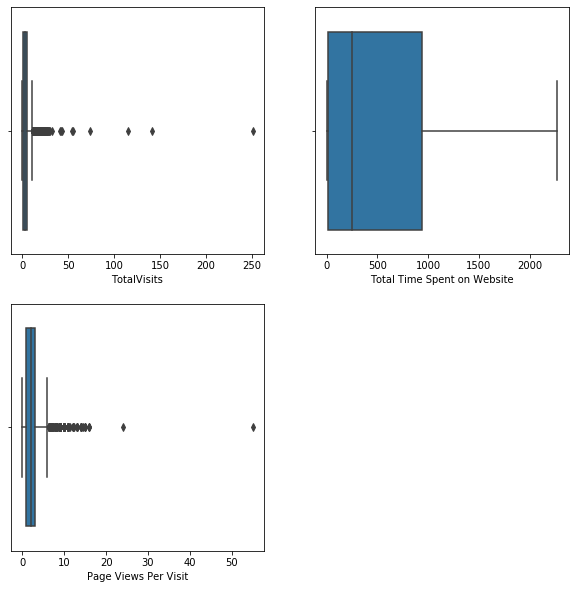

In [96]:
## box plot to check outliers
attributes = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
plt.figure(figsize=(10,10))

boxplots(attributes)

- Handling Outliers using the IQR method with boundaries as 15% and 85%

(9079, 12)


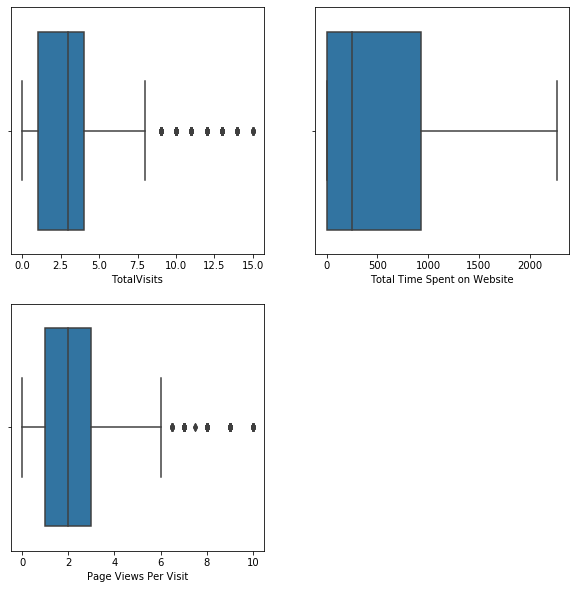

In [97]:
plt.figure(figsize=(10,10))
for i in enumerate(attributes):
        Q1 = leads[i[1]].quantile(0.15)
        Q3 = leads[i[1]].quantile(0.85)
        IQR = Q3 - Q1
        lower = Q1- IQR*1.5
        upper = Q3+ IQR*1.5
        leads = leads[(leads[i[1]] >= lower) & (leads[i[1]] <= upper)]
boxplots(attributes)
print(leads.shape)

In [98]:
leads_numeric = leads[['Converted', 'TotalVisits', 'Total Time Spent on Website','Page Views Per Visit', 'Last Notable Activity']]
leads_numeric.describe(percentiles=[.25, .5, .75, .90, .95, .99])
## from the below stats it can be seen that there are no major outliers in the data now.

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9079.000000,9079.000000,9079.000000,9079.000000
mean,0.385064,3.108382,483.604141,2.277804
std,0.486637,2.786944,546.838676,1.917527
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,8.000000,1.000000
50%,0.000000,3.000000,246.000000,2.000000
75%,1.000000,4.000000,929.000000,3.000000
90%,1.000000,7.000000,1377.000000,5.000000
95%,1.000000,9.000000,1558.000000,6.000000
99%,1.000000,12.000000,1839.220000,8.000000


In [99]:
#9240 intial number of rows to start with - 98% of the rows are retained 
round(100*(len(leads.index)/9240))

98

### Box plots of continous varibles against converted

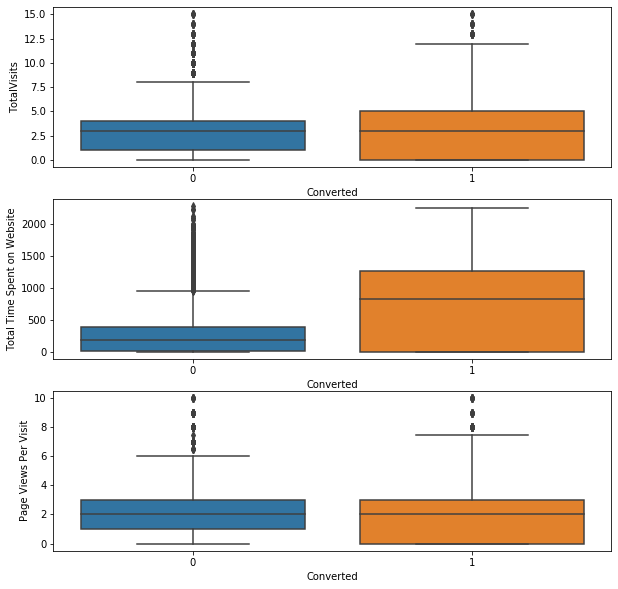

In [100]:
numerical_varibales = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
plt.figure(figsize=(10,10))

for var in enumerate(numerical_varibales):
    ax = plt.subplot(3, 1, var[0]+1)
    sns.boxplot(x='Converted', y= var[1], data=leads)

- It can be seen that mean of total visits for both converted and not converted is same. So Total visit does not play a major role in converting the leads.
- Cleary it can be seen that more the time spent on the site, higher is the conversion rate.
- Again as the mean comes out to be the same, no major insight can be drawn from this variable.

#### Count plots for categorical features

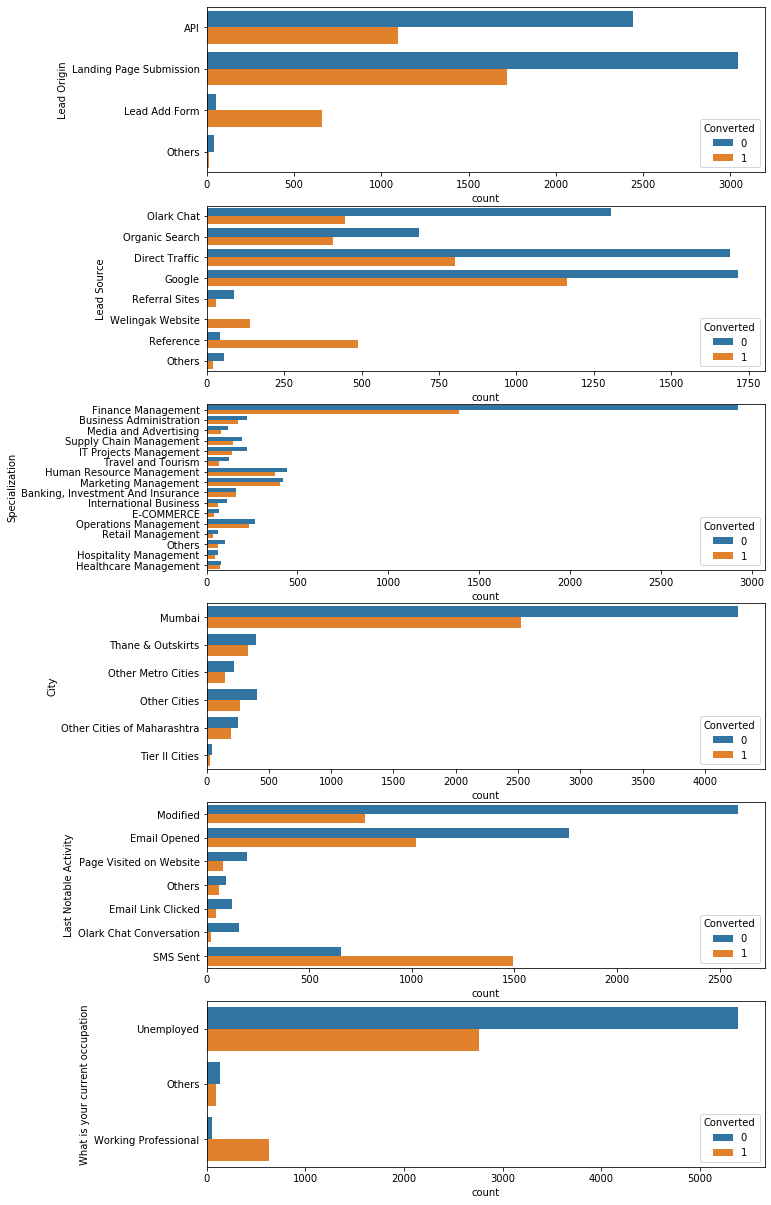

In [101]:
features = ['Lead Origin','Lead Source', 'Specialization','City', 'Last Notable Activity',
            'What is your current occupation']

plt.figure(figsize=(10,25))

for var in enumerate(features):
    ax = plt.subplot(7, 1, var[0]+1)
    sns.countplot(y=var[1], hue="Converted", data=leads)

- Most of the converted are from Landing page submission
- The main lead sources are google an ddirect traffic
- WE should target people who open their emails, or modified as they are highly likely to be converted
- Looks like finance people are the most interested ones for this course.
- Target people based out of Mumbai, also a lot of people are from unkown cities, they did not specify their city.
- Unemployed people are highly to be converted as they might want to upskill and use placement opportunities if provided by the course.

### Pair Plots

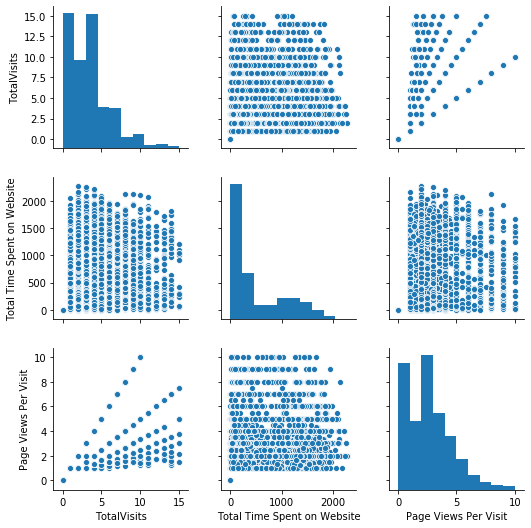

In [102]:
sns.pairplot(leads, vars=['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit'])
plt.show()

## There is some kind of relation between TotalVisits and Page Views Per visit

#### Distance plot to see the distribution of data

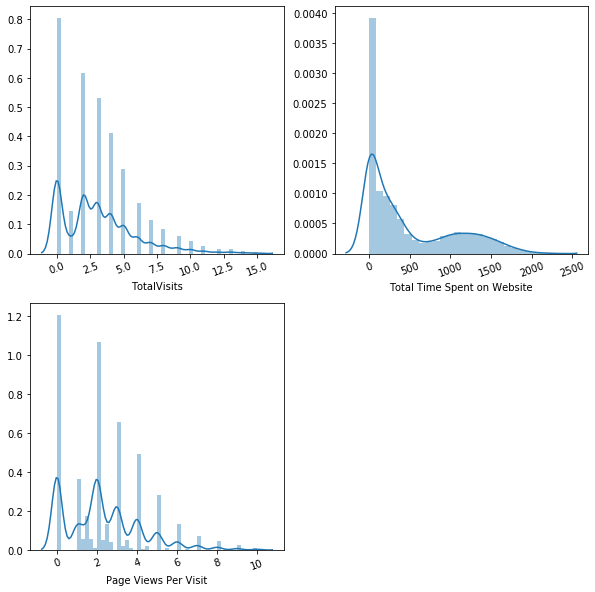

In [103]:
plt.figure(figsize = (10,10))
for i in enumerate(numerical_varibales):
    feat = plt.subplot(2,2,i[0]+1)
    sns.distplot(leads[i[1]])
    plt.xticks(rotation = 20)

- It can be seen that the data is nicely distributed and are not skewed now.

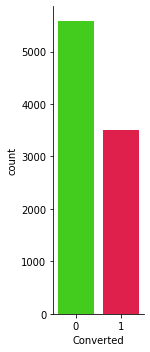

In [104]:
## Also let's see converted distribution
sns.catplot(x='Converted', kind='count', data=leads, palette='prism', aspect=0.4)

In [105]:
#38.5% of people tend to become customers
Converted = (sum(leads['Converted'])/len(leads['Converted'].index))*100
Converted

38.50644344090759

Heatmap for Numerical Variables

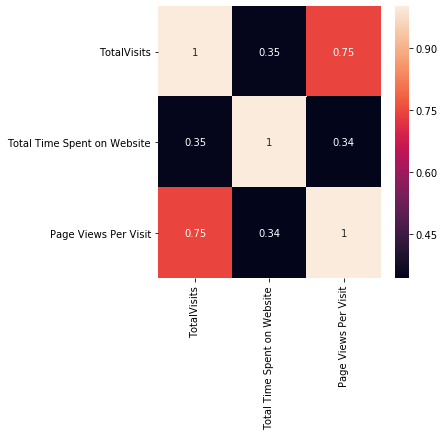

In [106]:
plt.figure(figsize = (5,5))
factors = leads[numerical_varibales]
leads_heatmap = sns.heatmap(data = factors.corr(), annot = True)
bottom, top = leads_heatmap.get_ylim()
leads_heatmap.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

## There is relation between PAge Views Per Visit and Total Visits

## 3. Data Preparation

In [107]:
# Displaying categroical values post bucketing, skewness is removed as a result of bucketing

categorical = ['Lead Origin','Lead Source', 'Last Notable Activity','Specialization','City','What is your current occupation']
for i in categorical:
    print(leads[i].value_counts(normalize=True))
    print('\n')

Landing Page Submission    0.524948
API                        0.390021
Lead Add Form              0.078863
Others                     0.006168
Name: Lead Origin, dtype: float64


Google              0.316885
Direct Traffic      0.274369
Olark Chat          0.192753
Organic Search      0.120388
Reference           0.058597
Welingak Website    0.015640
Referral Sites      0.012887
Others              0.008481
Name: Lead Source, dtype: float64


Modified                   0.370305
Email Opened               0.306972
SMS Sent                   0.236590
Page Visited on Website    0.030069
Olark Chat Conversation    0.020046
Email Link Clicked         0.018725
Others                     0.017293
Name: Last Notable Activity, dtype: float64


Finance Management                   0.475273
Marketing Management                 0.090979
Human Resource Management            0.090759
Operations Management                0.054962
Business Administration              0.043397
IT Projects Management  

In [108]:
# Creating dummies for lead origin column, deleting LeadOrigin_Others since it has spread

LeadOrigin = pd.get_dummies(leads['Lead Origin'], prefix = 'LeadOrigin')
LeadOrigin.drop('LeadOrigin_Others', inplace = True, axis =1)
LeadOrigin.head()

,LeadOrigin_API,LeadOrigin_Landing Page Submission,LeadOrigin_Lead Add Form
0,1,0,0
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0


In [109]:
# Creating dummies for lead source column, deleting LeadSource_Others since it has spread

LeadSource = pd.get_dummies(leads['Lead Source'], prefix = 'LeadSource')
LeadSource.drop('LeadSource_Others', inplace = True, axis =1)
LeadSource.head()

,LeadSource_Direct Traffic,LeadSource_Google,LeadSource_Olark Chat,LeadSource_Organic Search,LeadSource_Reference,LeadSource_Referral Sites,LeadSource_Welingak Website
0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0


In [110]:
# Creating dummies for Last Notable Activity column, deleting Last Notable Activity_Others since it has spread

LastActivity = pd.get_dummies(leads['Last Notable Activity'], prefix = 'LastNotableActivity')
LastActivity.drop('LastNotableActivity_Others', inplace = True, axis =1)
LastActivity

,LastNotableActivity_Email Link Clicked,LastNotableActivity_Email Opened,LastNotableActivity_Modified,LastNotableActivity_Olark Chat Conversation,LastNotableActivity_Page Visited on Website,LastNotableActivity_SMS Sent
0,0,0,1,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
9235,0,0,0,0,0,0
9236,0,0,0,0,0,1
9237,0,0,0,0,0,1
9238,0,0,0,0,0,1


In [111]:
# Creating dummies for Specialization column, deleting Specialization_Retail Management since it has spread

Specialization = pd.get_dummies(leads['Specialization'], prefix = 'Specialization')
Specialization.drop('Specialization_Retail Management', inplace = True, axis =1)
Specialization.head()

,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [112]:
# Creating dummies for City column, deleting City_Tier II Cities since it has spread

City = pd.get_dummies(leads['City'], prefix = 'City')
City.drop('City_Tier II Cities', inplace = True, axis =1)
City.head()

,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [113]:
# Creating dummies for Occupation column, deleting Occupation_Others since it has spread

Occupation = pd.get_dummies(leads['What is your current occupation'], prefix = 'Occupation')
Occupation.drop('Occupation_Others', inplace = True, axis =1)
Occupation.head()

,Occupation_Unemployed,Occupation_Working Professional
0,1,0
1,1,0
2,0,0
3,1,0
4,1,0


In [114]:
# Concatenating all newly created columns with main leads dataframe

leads = pd.concat([leads,Specialization,LastActivity,LeadOrigin,LeadSource,City,Occupation],axis = 1)
leads.head()

,Lead Number,Lead Origin,Lead Source,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Specialization,What is your current occupation,City,...,LeadSource_Reference,LeadSource_Referral Sites,LeadSource_Welingak Website,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,Occupation_Unemployed,Occupation_Working Professional
0,660737,API,Olark Chat,0,0.0,0,0.0,Finance Management,Unemployed,Mumbai,...,0,0,0,1,0,0,0,0,1,0
1,660728,API,Organic Search,0,5.0,674,2.5,Finance Management,Unemployed,Mumbai,...,0,0,0,1,0,0,0,0,1,0
2,660727,Landing Page Submission,Direct Traffic,1,2.0,1532,2.0,Business Administration,Others,Mumbai,...,0,0,0,1,0,0,0,0,0,0
3,660719,Landing Page Submission,Direct Traffic,0,1.0,305,1.0,Media and Advertising,Unemployed,Mumbai,...,0,0,0,1,0,0,0,0,1,0
4,660681,Landing Page Submission,Google,1,2.0,1428,1.0,Finance Management,Unemployed,Mumbai,...,0,0,0,1,0,0,0,0,1,0


In [115]:
# Removing the columns for which dummies have been created

leads.drop(['Lead Origin','Lead Source','Last Notable Activity','Specialization','City','What is your current occupation'],inplace = True, axis =1)
leads.head()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_E-COMMERCE,Specialization_Finance Management,...,LeadSource_Reference,LeadSource_Referral Sites,LeadSource_Welingak Website,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,Occupation_Unemployed,Occupation_Working Professional
0,660737,0,0.0,0,0.0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,660728,0,5.0,674,2.5,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,660727,1,2.0,1532,2.0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,660719,0,1.0,305,1.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,660681,1,2.0,1428,1.0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [116]:
# Displaying the columns info
print(leads.shape)
leads.info()

(9079, 44)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9079 entries, 0 to 9239
Data columns (total 44 columns):
Lead Number                                         9079 non-null int64
Converted                                           9079 non-null int64
TotalVisits                                         9079 non-null float64
Total Time Spent on Website                         9079 non-null int64
Page Views Per Visit                                9079 non-null float64
A free copy of Mastering The Interview              9079 non-null int32
Specialization_Banking, Investment And Insurance    9079 non-null uint8
Specialization_Business Administration              9079 non-null uint8
Specialization_E-COMMERCE                           9079 non-null uint8
Specialization_Finance Management                   9079 non-null uint8
Specialization_Healthcare Management                9079 non-null uint8
Specialization_Hospitality Management               9079 non-null uint8
Specialization

## 4: Splitting the Data into Training and Testing Set

In [117]:
# Deleting the variables which are not predictors
X = leads.drop(['Lead Number','Converted'], axis = 1)
y = leads['Converted']

In [118]:
# Splitting: Train data is 70% of the original size of leads and test data is 30% of the original size. 
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, test_size = 0.3, random_state = 100)

## 5 . Feature Scaling

In [119]:
# Using StandardScaler() object for scaling and to bring numerical variables in a normal scale

scaler = StandardScaler()
#Numerical Variables for scaling
X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])
X_train.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,...,LeadSource_Reference,LeadSource_Referral Sites,LeadSource_Welingak Website,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,Occupation_Unemployed,Occupation_Working Professional
2311,0.316850,0.724737,0.901792,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
6775,0.316850,-0.100878,0.901792,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6280,2.476957,1.555820,0.549376,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
9088,-0.403186,-0.853591,-0.150195,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
8458,-1.123222,-0.888220,-1.202181,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


## 6. Checking Correlations

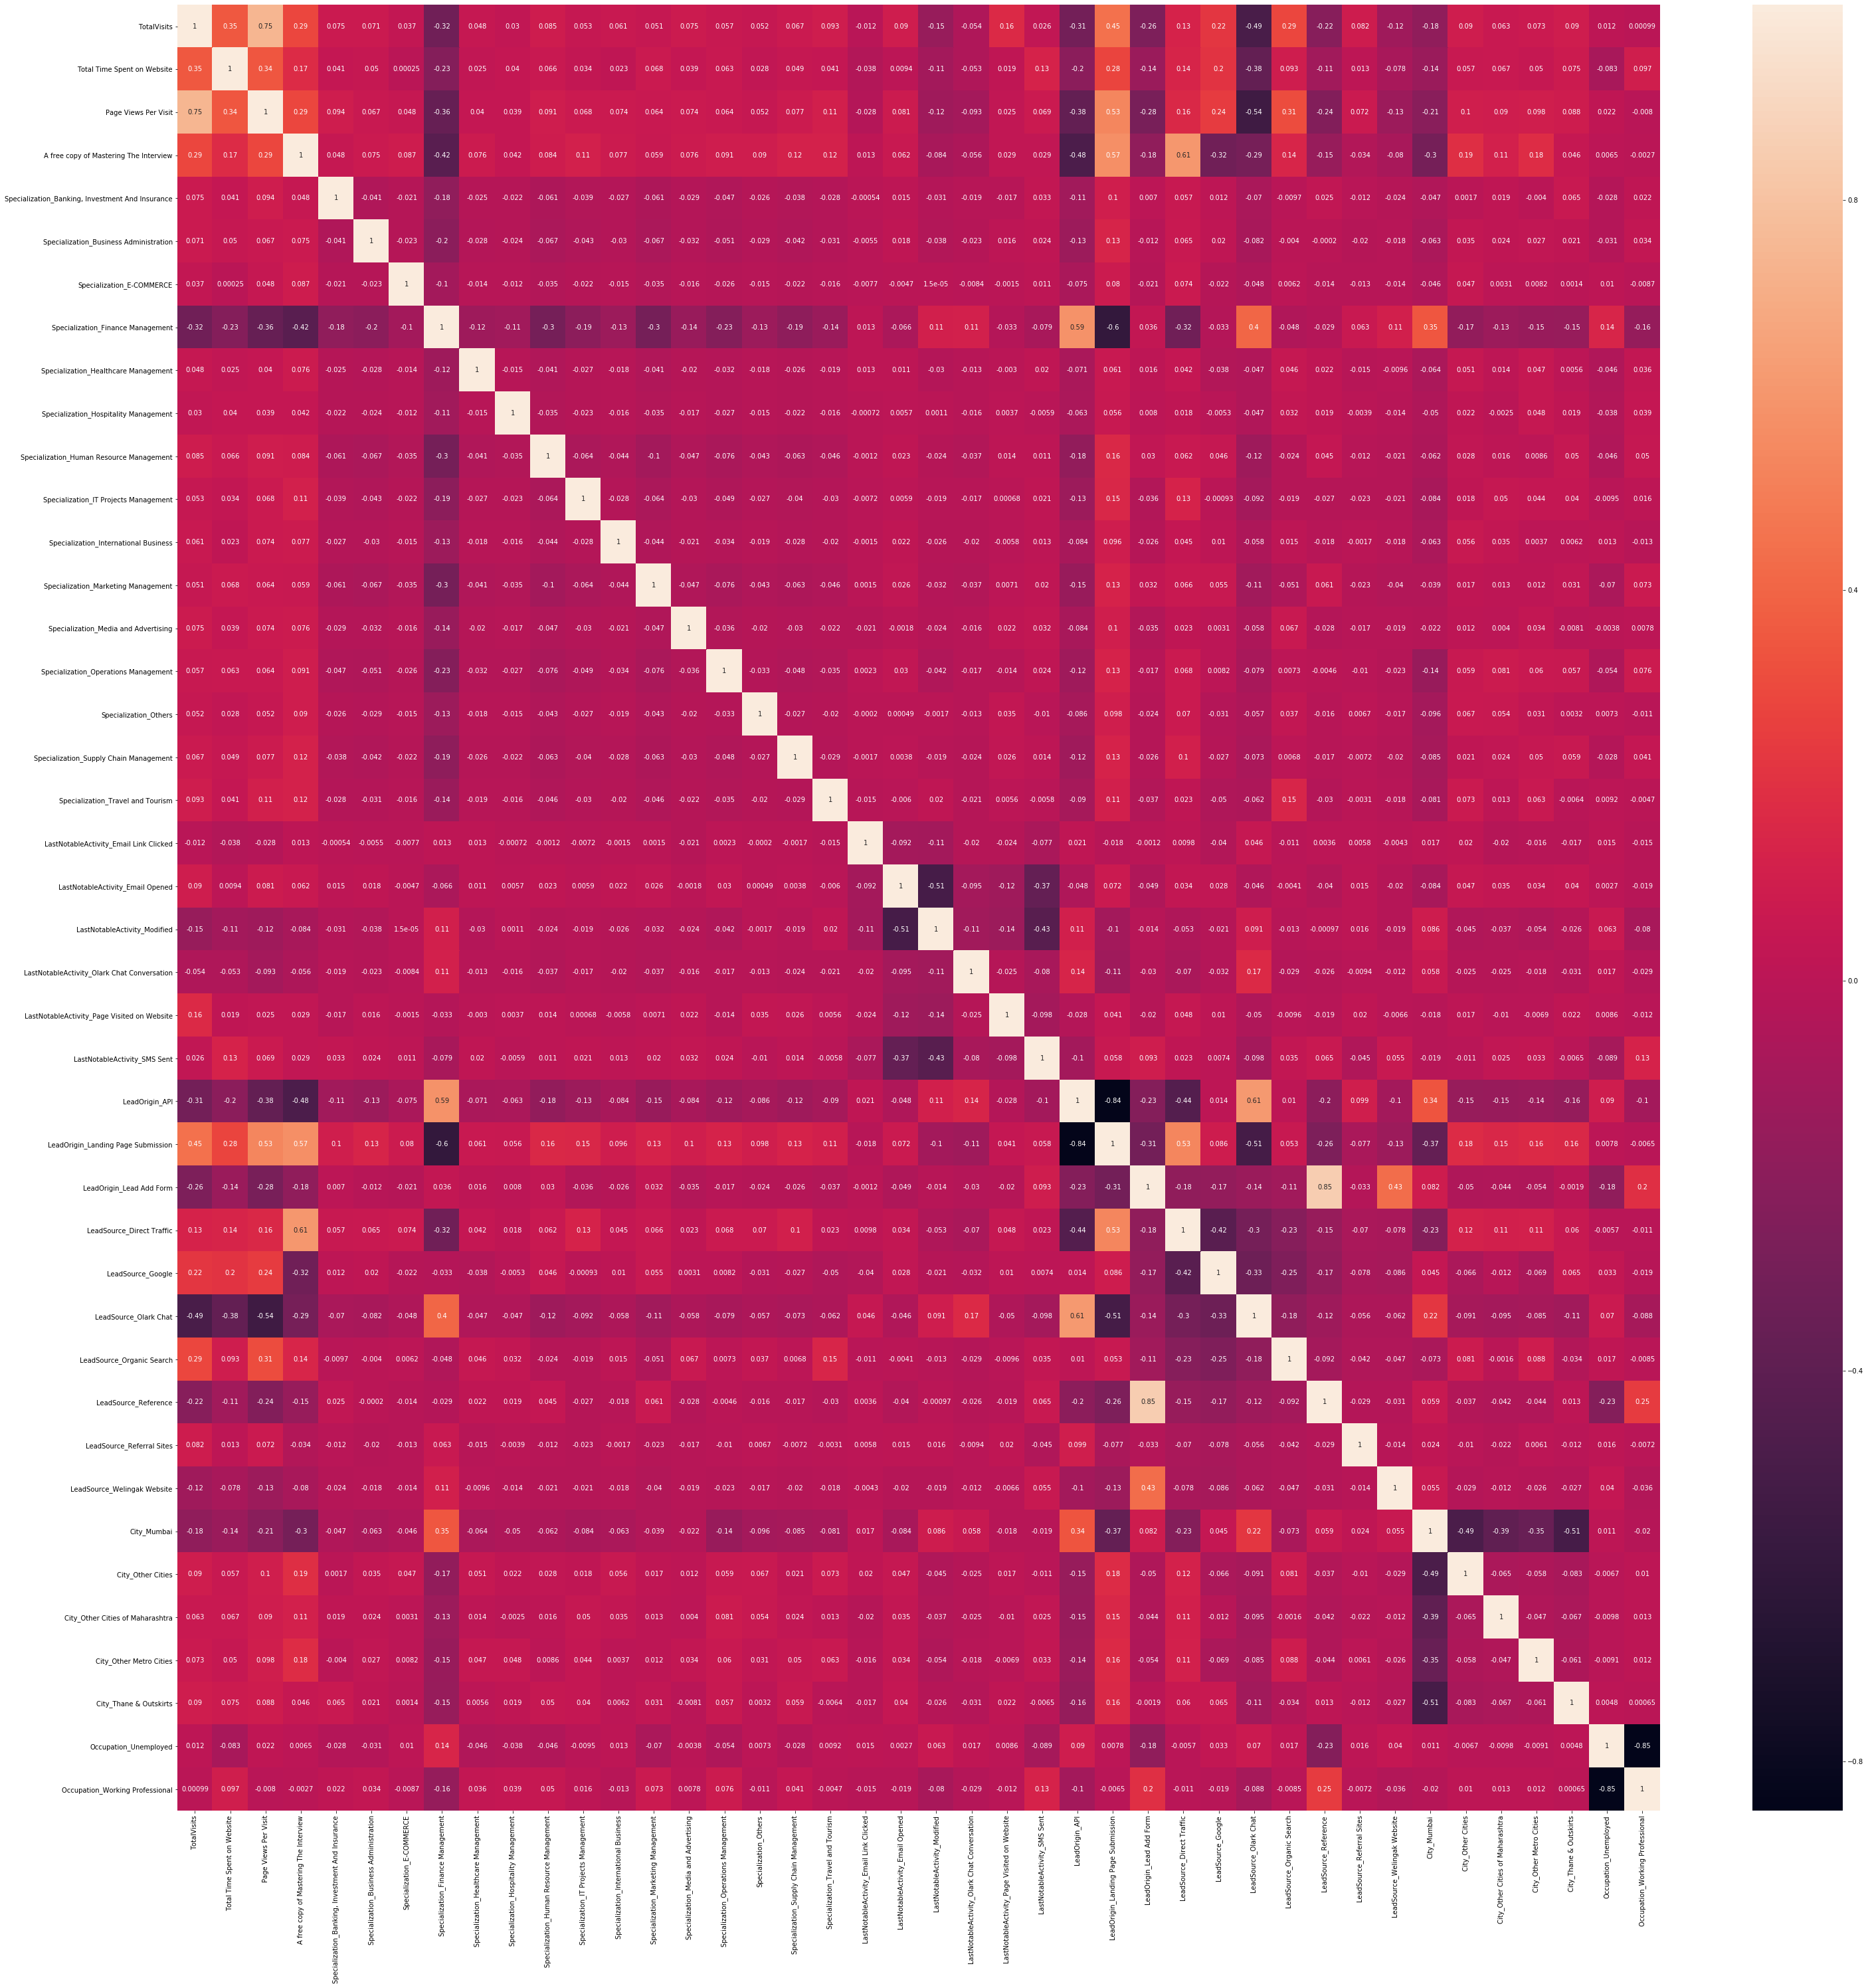

In [120]:
#correlation matrix to visulalize variables

plt.figure(figsize = (50,50)) 
leadsdf = leads[leads.columns[2:]]
leads_heatmap = sns.heatmap(leadsdf.corr(),annot = True)
bottom, top = leads_heatmap.get_ylim()
leads_heatmap.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [121]:
# Dropping highly correlated variables
X_train = X_train.drop(['LeadOrigin_Landing Page Submission','LeadSource_Olark Chat','Occupation_Unemployed',
         'Specialization_Finance Management','A free copy of Mastering The Interview',
         'TotalVisits','Page Views Per Visit'],axis = 1)
X_test = X_test.drop(['LeadOrigin_Landing Page Submission','LeadSource_Olark Chat','Occupation_Unemployed',
         'Specialization_Finance Management','A free copy of Mastering The Interview'],axis = 1)

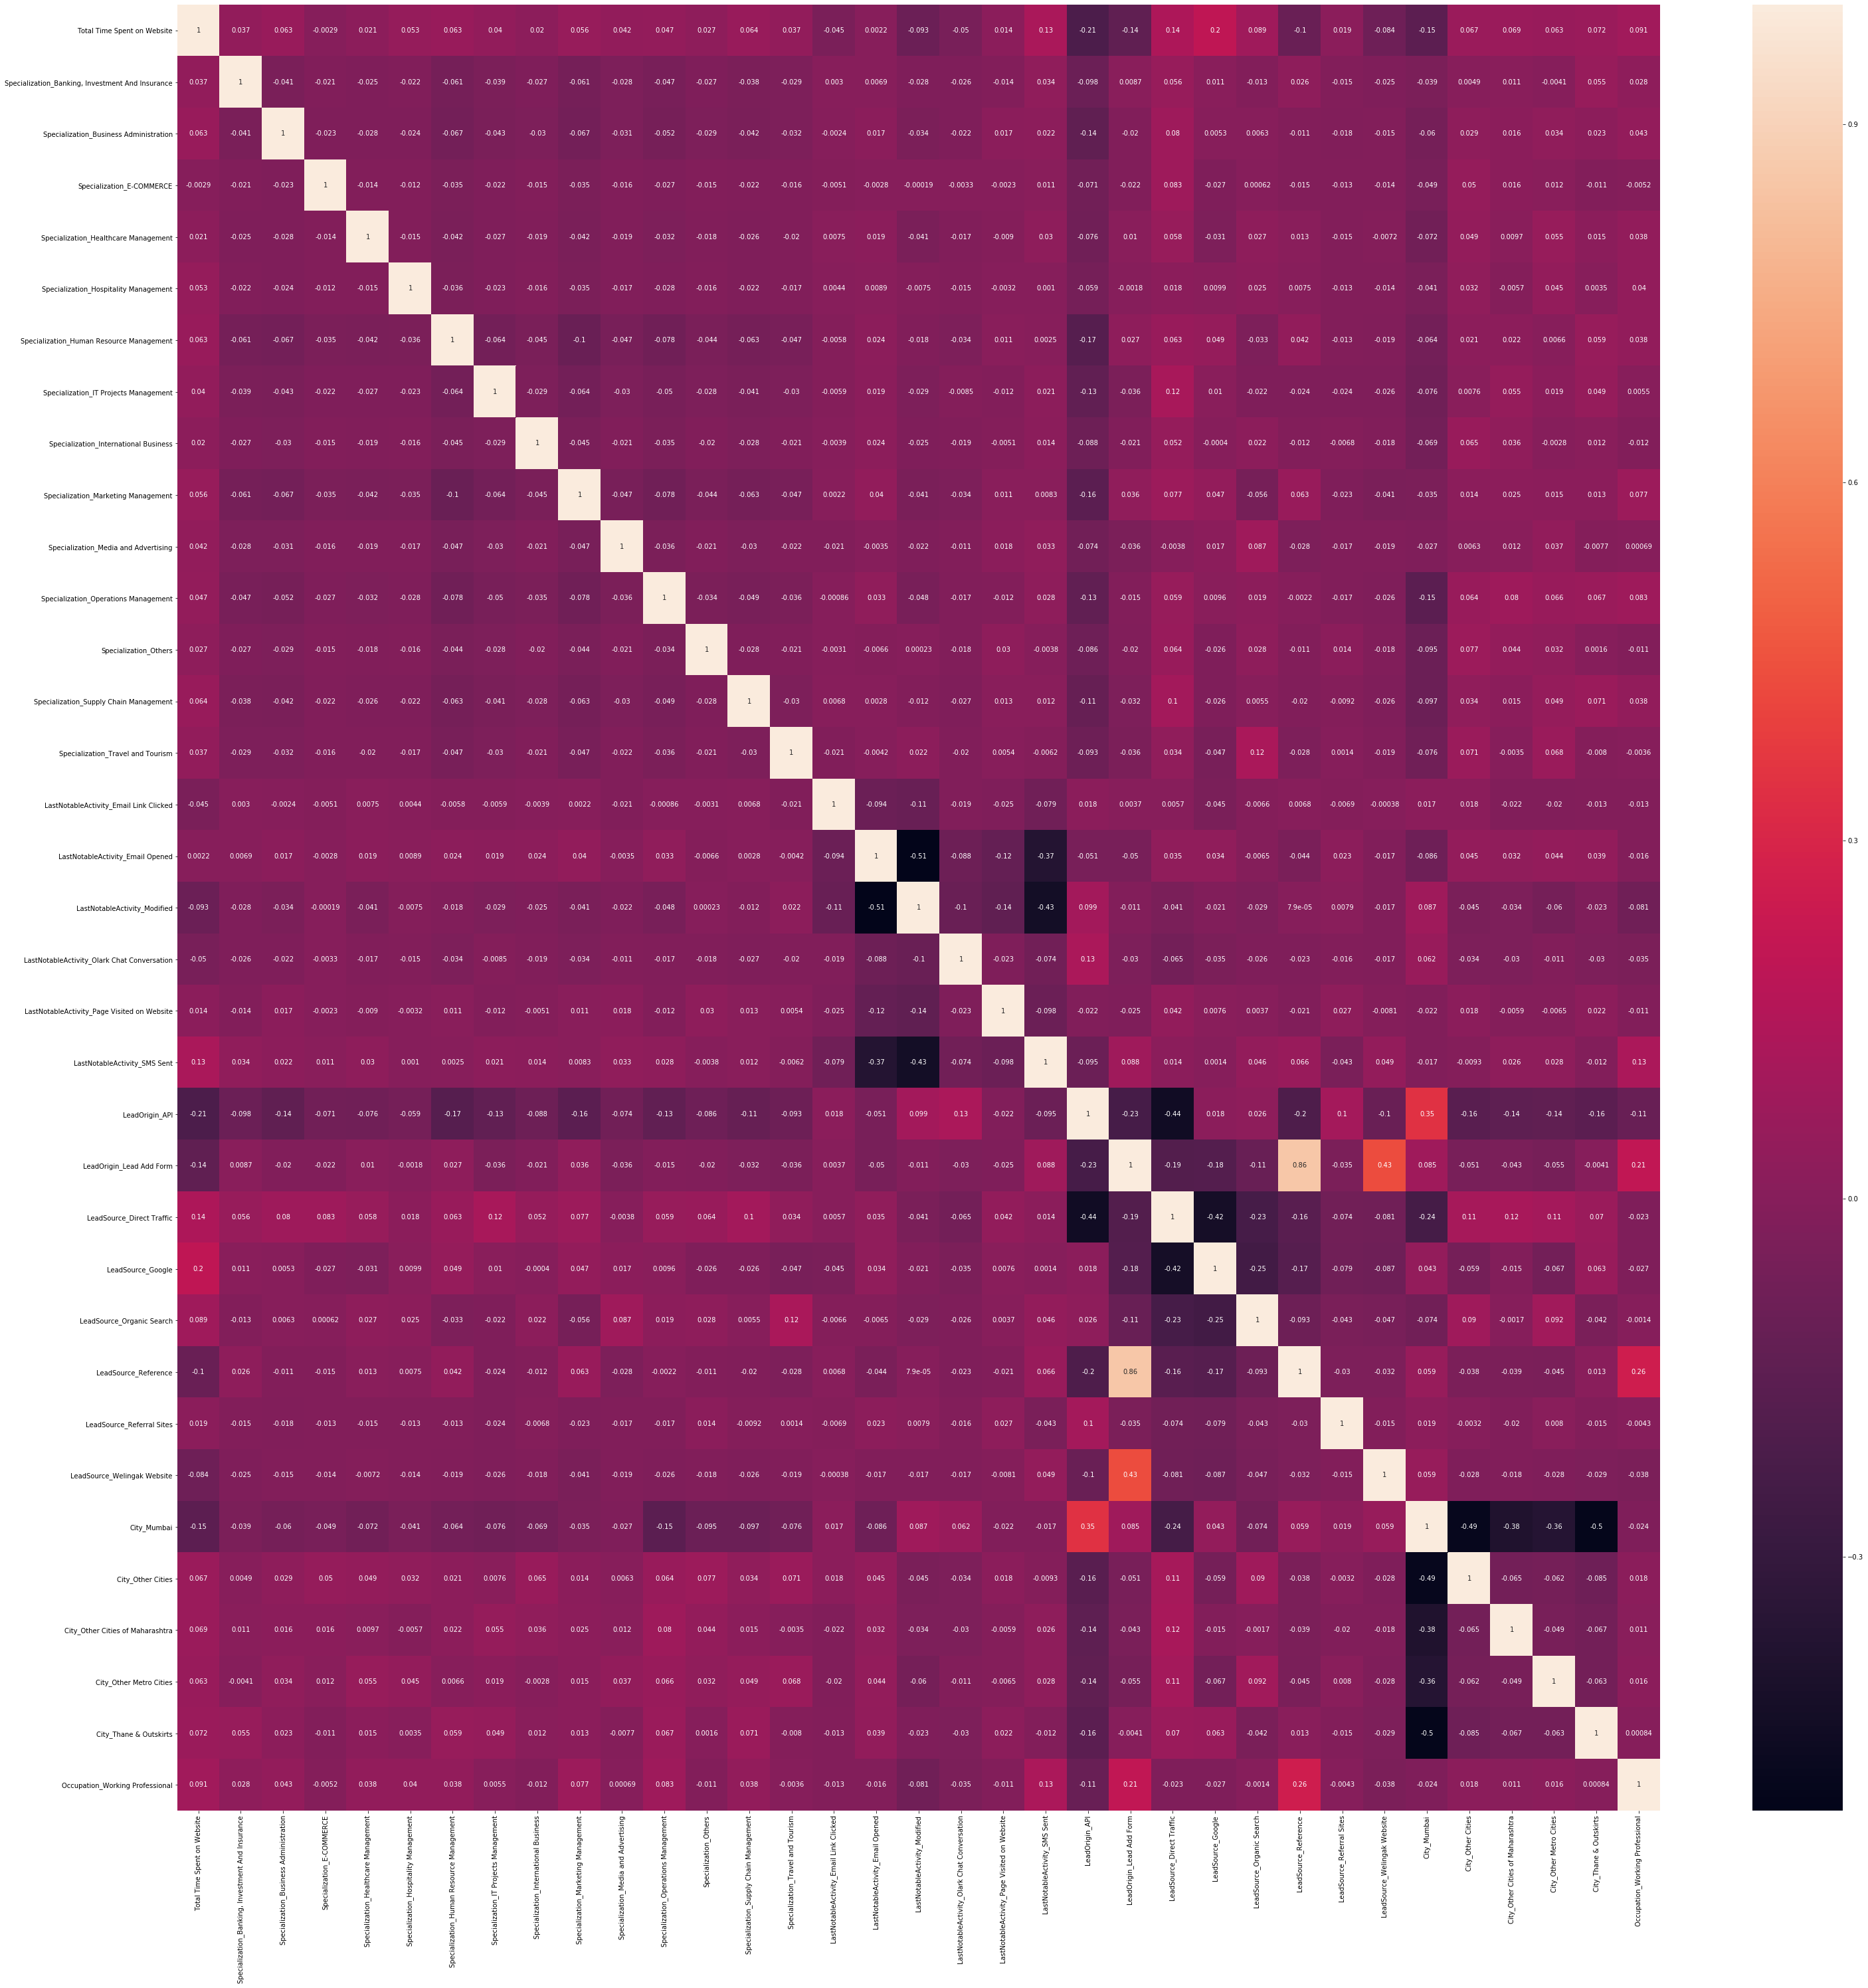

In [122]:
#correlation matrix to visulalize variables after removing higly correlated variables
# Leaving the rest for the model to decide the importance of variables

plt.figure(figsize = (50,50)) 
leads_heatmap = sns.heatmap(X_train.corr(),annot = True)
bottom, top = leads_heatmap.get_ylim()
leads_heatmap.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

## 7. Model Building

In [123]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
print(logm1.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6355
Model:                            GLM   Df Residuals:                     6319
Model Family:                Binomial   Df Model:                           35
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2671.9
Date:                Mon, 01 Jun 2020   Deviance:                       5343.9
Time:                        14:52:40   Pearson chi2:                 6.93e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

## 8. Feature Selection Using RFE

In [124]:
# Using tool for sklearn.linear_model to work wit RFE , instantiating LogisticRegression() 

logreg = LogisticRegression()
# running RFE with 15 variables as output - 15 top features are chosen by RFE

rfe = RFE(logreg, 15)             
rfe = rfe.fit(X_train, y_train)

In [125]:
# Ranking the variables are chosen by RFE
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Total Time Spent on Website', True, 1),
 ('Specialization_Banking, Investment And Insurance', True, 1),
 ('Specialization_Business Administration', False, 14),
 ('Specialization_E-COMMERCE', False, 5),
 ('Specialization_Healthcare Management', False, 13),
 ('Specialization_Hospitality Management', False, 17),
 ('Specialization_Human Resource Management', False, 4),
 ('Specialization_IT Projects Management', False, 2),
 ('Specialization_International Business', False, 7),
 ('Specialization_Marketing Management', True, 1),
 ('Specialization_Media and Advertising', False, 16),
 ('Specialization_Operations Management', False, 3),
 ('Specialization_Others', True, 1),
 ('Specialization_Supply Chain Management', False, 6),
 ('Specialization_Travel and Tourism', False, 9),
 ('LastNotableActivity_Email Link Clicked', True, 1),
 ('LastNotableActivity_Email Opened', False, 11),
 ('LastNotableActivity_Modified', True, 1),
 ('LastNotableActivity_Olark Chat Conversation', True, 1),
 ('LastNotable

In [126]:
# Copying variables are chosen by RFE into 'col'
col = X_train.columns[rfe.support_]
col

Index(['Total Time Spent on Website',
       'Specialization_Banking, Investment And Insurance',
       'Specialization_Marketing Management', 'Specialization_Others',
       'LastNotableActivity_Email Link Clicked',
       'LastNotableActivity_Modified',
       'LastNotableActivity_Olark Chat Conversation',
       'LastNotableActivity_SMS Sent', 'LeadOrigin_Lead Add Form',
       'LeadSource_Direct Traffic', 'LeadSource_Google',
       'LeadSource_Organic Search', 'LeadSource_Referral Sites',
       'LeadSource_Welingak Website', 'Occupation_Working Professional'],
      dtype='object')

In [127]:
# Displaying variables ignored by RFE
X_train.columns[~rfe.support_]

Index(['Specialization_Business Administration', 'Specialization_E-COMMERCE',
       'Specialization_Healthcare Management',
       'Specialization_Hospitality Management',
       'Specialization_Human Resource Management',
       'Specialization_IT Projects Management',
       'Specialization_International Business',
       'Specialization_Media and Advertising',
       'Specialization_Operations Management',
       'Specialization_Supply Chain Management',
       'Specialization_Travel and Tourism', 'LastNotableActivity_Email Opened',
       'LastNotableActivity_Page Visited on Website', 'LeadOrigin_API',
       'LeadSource_Reference', 'City_Mumbai', 'City_Other Cities',
       'City_Other Cities of Maharashtra', 'City_Other Metro Cities',
       'City_Thane & Outskirts'],
      dtype='object')

### Building Logistic Regression model with 15 features obtained from RFE

In [128]:
# Adding constant and re running stats GLM model to view the summary and assess pvalues

X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6355
Model:                            GLM   Df Residuals:                     6339
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2696.1
Date:                Mon, 01 Jun 2020   Deviance:                       5392.1
Time:                        14:52:41   Pearson chi2:                 6.90e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [129]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)

# Reshaping
y_train_pred = y_train_pred.values.reshape(-1)

# Creating dataframe with actual Converted and the respective probabilities predicted
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index

In [130]:
# Using 0.5 as a random cut off
y_train_pred_final['Predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,LeadID,Predicted
0,1,0.254321,2311,0
1,0,0.214760,6775,0
2,1,0.663053,6280,1
3,0,0.056001,9088,0
4,0,0.106022,8458,0


- Analyzing the model

In [131]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
confusion

array([[3471,  447],
       [ 739, 1698]], dtype=int64)

In [132]:
# Checking the Accuracy score of the model
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted))

0.813375295043273


In [133]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,LastNotableActivity_Modified,1.59
8,LeadOrigin_Lead Add Form,1.54
10,LeadSource_Google,1.51
7,LastNotableActivity_SMS Sent,1.49
9,LeadSource_Direct Traffic,1.49
13,LeadSource_Welingak Website,1.29
11,LeadSource_Organic Search,1.20
14,Occupation_Working Professional,1.19
2,Specialization_Marketing Management,1.14
0,Total Time Spent on Website,1.13


In [134]:
# Dropping Specialization_Others based on high p value
col = col.drop('Specialization_Others', 1)

# Adding constant and re running stats GLM model to view the summary and assess pvalues

X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6355
Model:                            GLM   Df Residuals:                     6340
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2697.3
Date:                Mon, 01 Jun 2020   Deviance:                       5394.5
Time:                        14:52:41   Pearson chi2:                 6.92e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

- Analysing The Model

In [135]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)

# Reshaping
y_train_pred = y_train_pred.values.reshape(-1)

# Creating dataframe with actual Converted and the respective probabilities predicted
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index

In [136]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['Predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,LeadID,Predicted
0,1,0.255610,2311,0
1,0,0.215514,6775,0
2,1,0.664579,6280,1
3,0,0.056357,9088,0
4,0,0.106319,8458,0


In [137]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
confusion

array([[3471,  447],
       [ 739, 1698]], dtype=int64)

In [138]:
# Check the overall accuracy. Thers's no sudden drop in accuracy, so we know we are going in a right direction
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted))

0.813375295043273


In [139]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,LastNotableActivity_Modified,1.59
7,LeadOrigin_Lead Add Form,1.54
9,LeadSource_Google,1.51
6,LastNotableActivity_SMS Sent,1.49
8,LeadSource_Direct Traffic,1.47
12,LeadSource_Welingak Website,1.29
10,LeadSource_Organic Search,1.19
13,Occupation_Working Professional,1.19
2,Specialization_Marketing Management,1.14
0,Total Time Spent on Website,1.13


In [140]:
# Dropping Specialization_Banking, Investment And Insurance based on high p value
col = col.drop('Specialization_Banking, Investment And Insurance', 1)

# Adding constant and re running stats GLM model to view the summary and assess pvalues

X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6355
Model:                            GLM   Df Residuals:                     6341
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2698.8
Date:                Mon, 01 Jun 2020   Deviance:                       5397.6
Time:                        14:52:42   Pearson chi2:                 6.93e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

- Analysing the model

In [141]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)

# Reshaping
y_train_pred = y_train_pred.values.reshape(-1)

# Creating dataframe with actual Converted and the respective probabilities predicted
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index

In [142]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['Predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,LeadID,Predicted
0,1,0.258105,2311,0
1,0,0.216174,6775,0
2,1,0.667865,6280,1
3,0,0.057037,9088,0
4,0,0.106603,8458,0


In [143]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
confusion

array([[3468,  450],
       [ 735, 1702]], dtype=int64)

In [144]:
# Checking the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted))

0.8135326514555468


In [145]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,LastNotableActivity_Modified,1.59
6,LeadOrigin_Lead Add Form,1.53
5,LastNotableActivity_SMS Sent,1.49
8,LeadSource_Google,1.49
7,LeadSource_Direct Traffic,1.45
11,LeadSource_Welingak Website,1.28
9,LeadSource_Organic Search,1.19
12,Occupation_Working Professional,1.19
0,Total Time Spent on Website,1.13
1,Specialization_Marketing Management,1.13


In [146]:
# Dropping LastNotableActivity_Email Link Clicked based on high p value
col = col.drop('LastNotableActivity_Email Link Clicked', 1)

# Adding constant and re running stats GLM model to view the summary and assess pvalues

X_train_sm = sm.add_constant(X_train[col])
logm5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm5.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6355
Model:                            GLM   Df Residuals:                     6342
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2700.5
Date:                Mon, 01 Jun 2020   Deviance:                       5401.0
Time:                        14:52:42   Pearson chi2:                 6.92e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

- Analysing the Model

In [147]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)

# Reshaping
y_train_pred = y_train_pred.values.reshape(-1)

# Creating dataframe with actual Converted and the respective probabilities predicted
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index

In [148]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['Predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,LeadID,Predicted
0,1,0.259110,2311,0
1,0,0.212323,6775,0
2,1,0.664098,6280,1
3,0,0.057252,9088,0
4,0,0.105823,8458,0


In [149]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
confusion

array([[3466,  452],
       [ 737, 1700]], dtype=int64)

In [150]:
# Check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted))

0.8129032258064516


In [151]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,LastNotableActivity_Modified,1.57
5,LeadOrigin_Lead Add Form,1.53
4,LastNotableActivity_SMS Sent,1.48
7,LeadSource_Google,1.48
6,LeadSource_Direct Traffic,1.42
10,LeadSource_Welingak Website,1.28
11,Occupation_Working Professional,1.19
8,LeadSource_Organic Search,1.18
1,Specialization_Marketing Management,1.13
0,Total Time Spent on Website,1.12


#### All the features are significant and have reasoable VIF.
- So let's go forward with this model

In [152]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [153]:
# Sensitivity of logistic regression model
TP / float(TP+FN)

0.6975789905621665

In [154]:
# Specificity of logistic regression model
TN/float(TN+FP)

0.8846350178662583

## 9. Plotting a ROC Curve:

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [155]:
# Function for defining ROC Curve

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [156]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Converted_Prob, drop_intermediate = False )

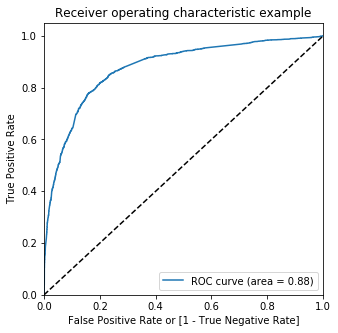

In [157]:
# Calling draw_roc curve with values obtained by roc_curve tool

draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

## Area under the curve is 0.88
## the curve is bent more towards the upper left corner. This indicates a better performance.

## 10.  Finding optimal Cut-off

In [158]:
# Creating columns with different probability cutoffs 
# If the probability is below the cutoff, it will labelled as 0 else labelled as 1

numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,LeadID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.259110,2311,0,1,1,1,0,0,0,0,0,0,0
1,0,0.212323,6775,0,1,1,1,0,0,0,0,0,0,0
2,1,0.664098,6280,1,1,1,1,1,1,1,1,0,0,0
3,0,0.057252,9088,0,1,0,0,0,0,0,0,0,0,0
4,0,0.105823,8458,0,1,1,0,0,0,0,0,0,0,0


In [159]:
# Calculating accuracy,sensitivity and specificity for various probability cutoffs.

cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1    
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensitivity,specificity]
print(cutoff_df)

     prob  accuracy  sensitivity  specificity
0.0   0.0  0.383478     1.000000     0.000000
0.1   0.1  0.546499     0.970866     0.282542
0.2   0.2  0.740677     0.912597     0.633742
0.3   0.3  0.798899     0.836684     0.775396
0.4   0.4  0.816994     0.772671     0.844564
0.5   0.5  0.812903     0.697579     0.884635
0.6   0.6  0.795279     0.588839     0.923686
0.7   0.7  0.776869     0.498974     0.949719
0.8   0.8  0.756412     0.416496     0.967841
0.9   0.9  0.717231     0.282725     0.987494


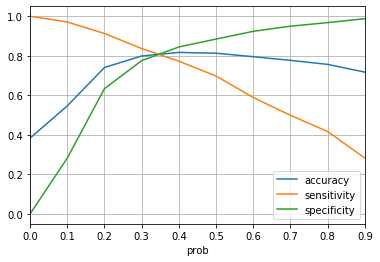

In [160]:
# Plotting accuracy,sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])
plt.grid()
plt.show()

#### 0.35 is the optimal cutoff point based on the plot above. 3 metrics Accuracy,Sensitivity and Specificity is balanced & almost equal at 0.35 cutoff.

- Drawing conclusions using cut-off 0.5

In [161]:
# Drawing confusion matrix for initial cut off of 0.5
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
confusion

array([[3466,  452],
       [ 737, 1700]], dtype=int64)

In [162]:
# Checking the Precision of our logistic regression model with 0.5 cutoff
precision_score(y_train_pred_final.Converted, y_train_pred_final.Predicted)

0.7899628252788105

In [163]:
# Checking the recall of our logistic regression model with 0.5 cutoff
recall_score(y_train_pred_final.Converted, y_train_pred_final.Predicted)

0.6975789905621665

In [164]:
# Converted Vs Predicted 
y_train_pred_final.Converted, y_train_pred_final.Predicted

(0       1
 1       0
 2       1
 3       0
 4       0
        ..
 6350    0
 6351    1
 6352    0
 6353    0
 6354    0
 Name: Converted, Length: 6355, dtype: int64, 0       0
 1       0
 2       1
 3       0
 4       0
        ..
 6350    0
 6351    1
 6352    1
 6353    1
 6354    0
 Name: Predicted, Length: 6355, dtype: int64)

In [165]:
# Assigning Precision, recall and threshold variables
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

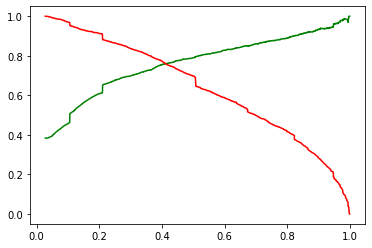

In [166]:
# Plotting Precision, recall against threshold variable - 0.41 is the optimal cut off according to this
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()


- Drawing conclusion from cut-off 0.35

In [167]:
# Final_predicted column will have predicted values based on 0.35 cutoff
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_Prob.map( lambda x: 1 if x > 0.35 else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,LeadID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.259110,2311,0,1,1,1,0,0,0,0,0,0,0,0
1,0,0.212323,6775,0,1,1,1,0,0,0,0,0,0,0,0
2,1,0.664098,6280,1,1,1,1,1,1,1,1,0,0,0,1
3,0,0.057252,9088,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.105823,8458,0,1,1,0,0,0,0,0,0,0,0,0


In [168]:
# Checking the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8088119590873328

In [169]:
# Confusion matrix for depicting changed values based on new cutoff - Going ahead with based on Sensitivity,Specificity
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[3167,  751],
       [ 464, 1973]], dtype=int64)

In [170]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [171]:
# Checking the sensitivity/recall of our logistic regression model - Given as above 80% which satisfies our business expectation
Sensitivity = TP / float(TP+FN)
Sensitivity

0.8096019696347969

In [172]:
# Checking the Precision of our logistic regression model
Precision = TP/float(TP+FP)
Precision

0.7243024963289281

In [173]:
# F=2×precision×recall/precision+recall - Used to look at the performance of sensitivity and precision together
# Calculating F1-Score - above 0.75 is a good value
F = 2 * ((Sensitivity * Precision)/(Sensitivity + Precision))
F

0.7645805076535555

- The F1 score is greater than 75%, so we can say that the model is well explained

## 11. Making Predictions on Test set

- Scaling the features

In [174]:
# Scaling the features
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

X_test = X_test[col]
X_test.head() 

,Total Time Spent on Website,Specialization_Marketing Management,LastNotableActivity_Modified,LastNotableActivity_Olark Chat Conversation,LastNotableActivity_SMS Sent,LeadOrigin_Lead Add Form,LeadSource_Direct Traffic,LeadSource_Google,LeadSource_Organic Search,LeadSource_Referral Sites,LeadSource_Welingak Website,Occupation_Working Professional
1552,1.716205,0,0,0,1,0,0,1,0,0,0,1
7233,-0.272198,0,0,0,0,0,1,0,0,0,0,0
7257,2.051554,0,0,0,0,0,1,0,0,0,0,0
2724,-0.787980,0,0,0,0,0,0,1,0,0,0,0
2166,1.442822,0,0,0,1,0,0,1,0,0,0,0


In [175]:
# Adding constant 
X_test_sm = sm.add_constant(X_test)

# Making the predictions based on train set 
y_test_pred = res.predict(X_test_sm)

# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [176]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

# Putting CustID to index
y_test_df['LeadID'] = y_test_df.index

In [177]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [178]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [179]:
y_pred_final.head()

,Converted,LeadID,0
0,1,1552,0.992672
1,0,7233,0.138814
2,0,7257,0.679706
3,0,2724,0.128060
4,1,2166,0.870735


In [180]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_Prob'})

In [181]:
# Based on Sensitivity,Specificity using 0.35 as the cut off
y_pred_final['final_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.35 else 0)

In [182]:
y_pred_final.head()

,Converted,LeadID,Converted_Prob,final_predicted
0,1,1552,0.992672,1
1,0,7233,0.138814,0
2,0,7257,0.679706,1
3,0,2724,0.128060,0
4,1,2166,0.870735,1


- Analysing the test Model

In [183]:
# Checking the overall accuracy.
# 0.808 was train set accuracy, 0.792 is test set accuracy which is good
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.7922173274596183

In [184]:
# Creating confusion matrix with new set of values based on cut off of 0.35
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
confusion2

array([[1334,  331],
       [ 235,  824]], dtype=int64)

In [185]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [186]:
# Sensitivity of our logistic regression model
# 0.809 was sensitivity of train set, 0.778 is sensitivity of test set - Model is well built, meets expectations
TP / float(TP+FN)

0.7780925401322002

In [187]:
# Checking the Precision of our logistic regression model
Precision = TP/float(TP+FP)
Precision

0.7134199134199134

In [188]:
# F=2×precision×recall/precision+recall - Used to look at the performance of sensitivity and precision together
# Calculating F1-Score - above 0.75 is a good value
F = 2 * ((Sensitivity * Precision)/(Sensitivity + Precision))
F

0.7584738912916854

### Concatenate test and train dataframe

In [189]:
lead_pred = y_train_pred_final.append(y_pred_final)
lead_pred = lead_pred[['Converted', 'Converted_Prob', 'LeadID', 'final_predicted']]
lead_pred.head()

,Converted,Converted_Prob,LeadID,final_predicted
0,1,0.259110,2311,0
1,0,0.212323,6775,0
2,1,0.664098,6280,1
3,0,0.057252,9088,0
4,0,0.105823,8458,0


In [190]:
print(y_train_pred_final.shape)
print(y_pred_final.shape)
print(lead_pred.shape)

(6355, 15)
(2724, 4)
(9079, 4)


In [191]:
lead_pred['Score'] = lead_pred['Converted_Prob'].apply(lambda x: round(x*100))

In [192]:
lead_pred.head()

,Converted,Converted_Prob,LeadID,final_predicted,Score
0,1,0.259110,2311,0,26
1,0,0.212323,6775,0,21
2,1,0.664098,6280,1,66
3,0,0.057252,9088,0,6
4,0,0.105823,8458,0,11


In [193]:
## MAke leadNUmber as index
lead_pred = lead_pred.set_index('LeadID').sort_index(axis=0, ascending=True)

In [194]:
lead_pred.head()

,Converted,Converted_Prob,final_predicted,Score
LeadID,,,,
0,0,0.105823,0,11
1,0,0.286118,0,29
2,1,0.643060,1,64
3,0,0.062842,0,6
4,1,0.511786,1,51


In [195]:
lead_pred.sort_values(by='Score', ascending=False, inplace=True)

In [196]:
# Choosing Score as 35 based on sensitivity-specificity curve cut off of 35% based on. 

likely_to_be_Converted = lead_pred[ (lead_pred['Score'] > 35) ]

In [197]:
print(likely_to_be_Converted.shape)
likely_to_be_Converted.head()

(3846, 4)


,Converted,Converted_Prob,final_predicted,Score
LeadID,,,,
5822,1,0.996250,1,100
2674,1,0.996250,1,100
2672,1,0.996250,1,100
5695,1,0.996250,1,100
5697,1,0.997286,1,100


In [198]:
# If company’s aim is to not make phone calls unless it’s extremely necessary, i.e. they want to minimize the rate of useless phone calls. 
# We can use a extreme score of 80 in this situation


likely_to_be_Converted = lead_pred[ (lead_pred['Score'] > 80) ]

In [199]:
print(likely_to_be_Converted.shape)
likely_to_be_Converted.head()

(1577, 4)


,Converted,Converted_Prob,final_predicted,Score
LeadID,,,,
5822,1,0.996250,1,100
2674,1,0.996250,1,100
2672,1,0.996250,1,100
5695,1,0.996250,1,100
5697,1,0.997286,1,100


In [200]:
# Displaying Final variables

pd.options.display.float_format = '{:.2f}'.format
new_params = res.params[1:]
new_params

Total Time Spent on Website                    1.11
Specialization_Marketing Management            0.32
LastNotableActivity_Modified                  -0.81
LastNotableActivity_Olark Chat Conversation   -1.60
LastNotableActivity_SMS Sent                   1.35
LeadOrigin_Lead Add Form                       2.86
LeadSource_Direct Traffic                     -1.18
LeadSource_Google                             -0.71
LeadSource_Organic Search                     -0.95
LeadSource_Referral Sites                     -1.15
LeadSource_Welingak Website                    2.20
Occupation_Working Professional                2.70
dtype: float64

### The final features for the model are:
 - Total Time Spent on Website
 - Specialization_Marketing Management
 - LastNotableActivity_Modified
 - LastNotableActivity_Olark Chat Conversation
 - LastNotableActivity_SMS Sent
 - LeadOrigin_Lead Add Form
 - LeadSource_Direct Traffic
 - LeadSource_Google
 - LeadSource_Organic Search
 - LeadSource_Referral Sites
 - LeadSource_Welingak Website
 - Occupation_Working Professional

### The top variables describing the model are:
 - LeadSource_Welingak Website
 - Occupation_Working Professional 
 - LeadOrigin_Lead Add Form

### There are around 3846 people who are identified as hot leads as they have probablity score greater than 35
### There are around 1577 people who are identified as hot leads as they have probablity score greater than 80